スマホでの測位、標準マイクのデータベースそのまま使用


In [1]:
import sys

sys.path.append("../")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
from positioning.readwav import readwav
from positioning.get_spectrum_amplitude import get_spectrum_amplitude
from positioning.sound_db import SoundDB
from positioning import tools

In [3]:
db = SoundDB("../data/reference_2d", interval=0.2, dim=2)

In [4]:
true_pos = pd.read_csv("../data/phone-pos_20230911/true_positions.csv", index_col=0)

In [5]:
est_poses = []
est_polars = []
errors = []
for i in range(20):
    test_signal = readwav(f"../data/phone-pos_20230911/test{i}.wav")
    err = []
    pos = []
    polar = []
    for j in range(100):
        est_polar = np.ravel(
            db.positioning(test_signal[j * 96000 : (j + 2) * 96000], output="polar")
        )
        est_pos = tools.polar_to_rect(est_polar[1], np.radians(est_polar[0]))
        pos.append(est_pos)
        polar.append(est_polar)
        err.append(np.linalg.norm(est_pos - true_pos.iloc[i]))
    est_poses.append(pos)
    est_polars.append(polar)
    errors.append(err)

In [6]:
df_est = pd.DataFrame()
for i in range(20):
    df_est_pos = pd.DataFrame(est_poses[i], columns=["x", "y"])
    df_est_pos["azimuth"] = np.array(est_polars[i])[:, 0]
    df_est_pos["distance"] = np.array(est_polars[i])[:, 1]
    df_est_pos["error"] = errors[i]
    df_est_pos["test_position"] = f"test{i}"
    df_est = pd.concat([df_est, df_est_pos])
df_est.reset_index(inplace=True, drop=True)

In [7]:
df_est.head()

,x,y,azimuth,distance,error,test_position
0,0.271466,0.402465,34.0,0.485461,1.003491,test0
1,0.270047,0.400361,34.0,0.482923,1.003305,test0
2,0.269405,0.399410,34.0,0.481775,1.003223,test0
3,0.268938,0.398717,34.0,0.480939,1.003164,test0
4,0.270213,0.400607,34.0,0.483219,1.003326,test0


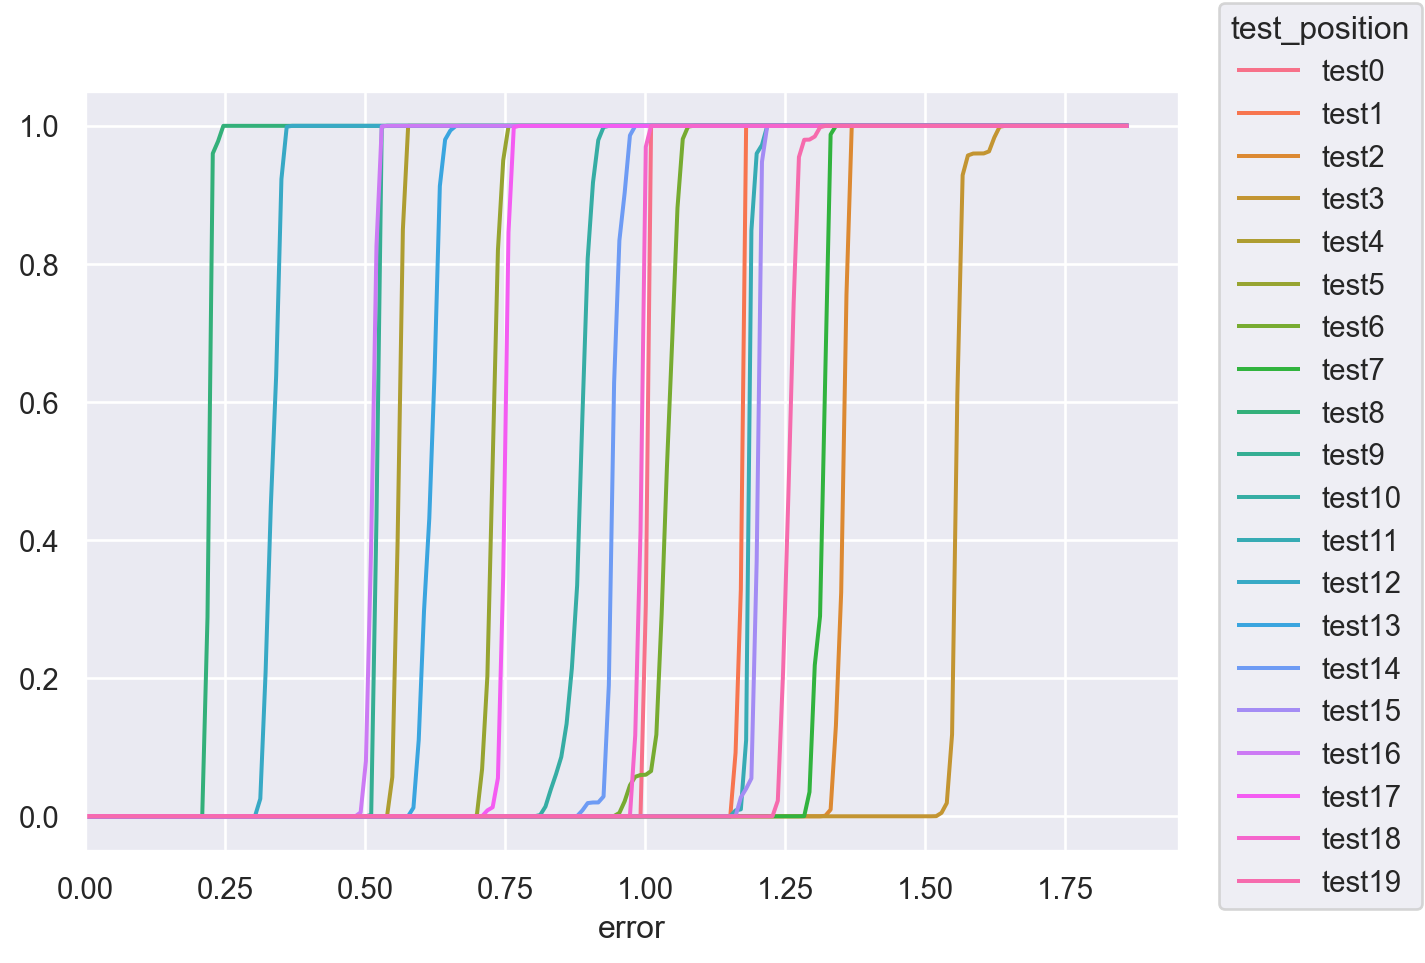

In [8]:
(
    so.Plot(df_est, x="error", color="test_position")
    .add(so.Lines(), so.KDE(cumulative=True, common_norm=False))
    .limit(x=(0, None))
)

In [13]:
sns.set_theme()

(0.0, 1.6957796753859533)

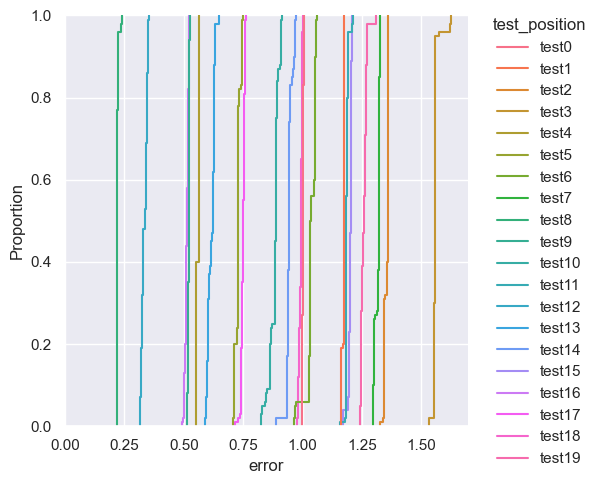

In [15]:
sns.displot(df_est, x="error", hue="test_position", kind="ecdf")
plt.xlim(0, None)

In [9]:
df_positions = df_est[["x", "y", "test_position"]]
df_positions.loc[:, "true_or_test"] = "test"
true_pos["test_position"] = true_pos.index
true_pos["true_or_test"] = "true"
df_positions = pd.concat([df_positions, true_pos])
df_positions.reset_index(drop=True, inplace=True)
df_positions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2020 entries, 0 to 2019
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   x              2020 non-null   float64
 1   y              2020 non-null   float64
 2   test_position  2020 non-null   object 
 3   true_or_test   2020 non-null   object 
dtypes: float64(2), object(2)
memory usage: 63.3+ KB


/var/folders/y1/_8gjlcgj5vd54qpx7m_q4hlw0000gn/T/ipykernel_33312/2238469347.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_positions.loc[:, "true_or_test"] = "test"


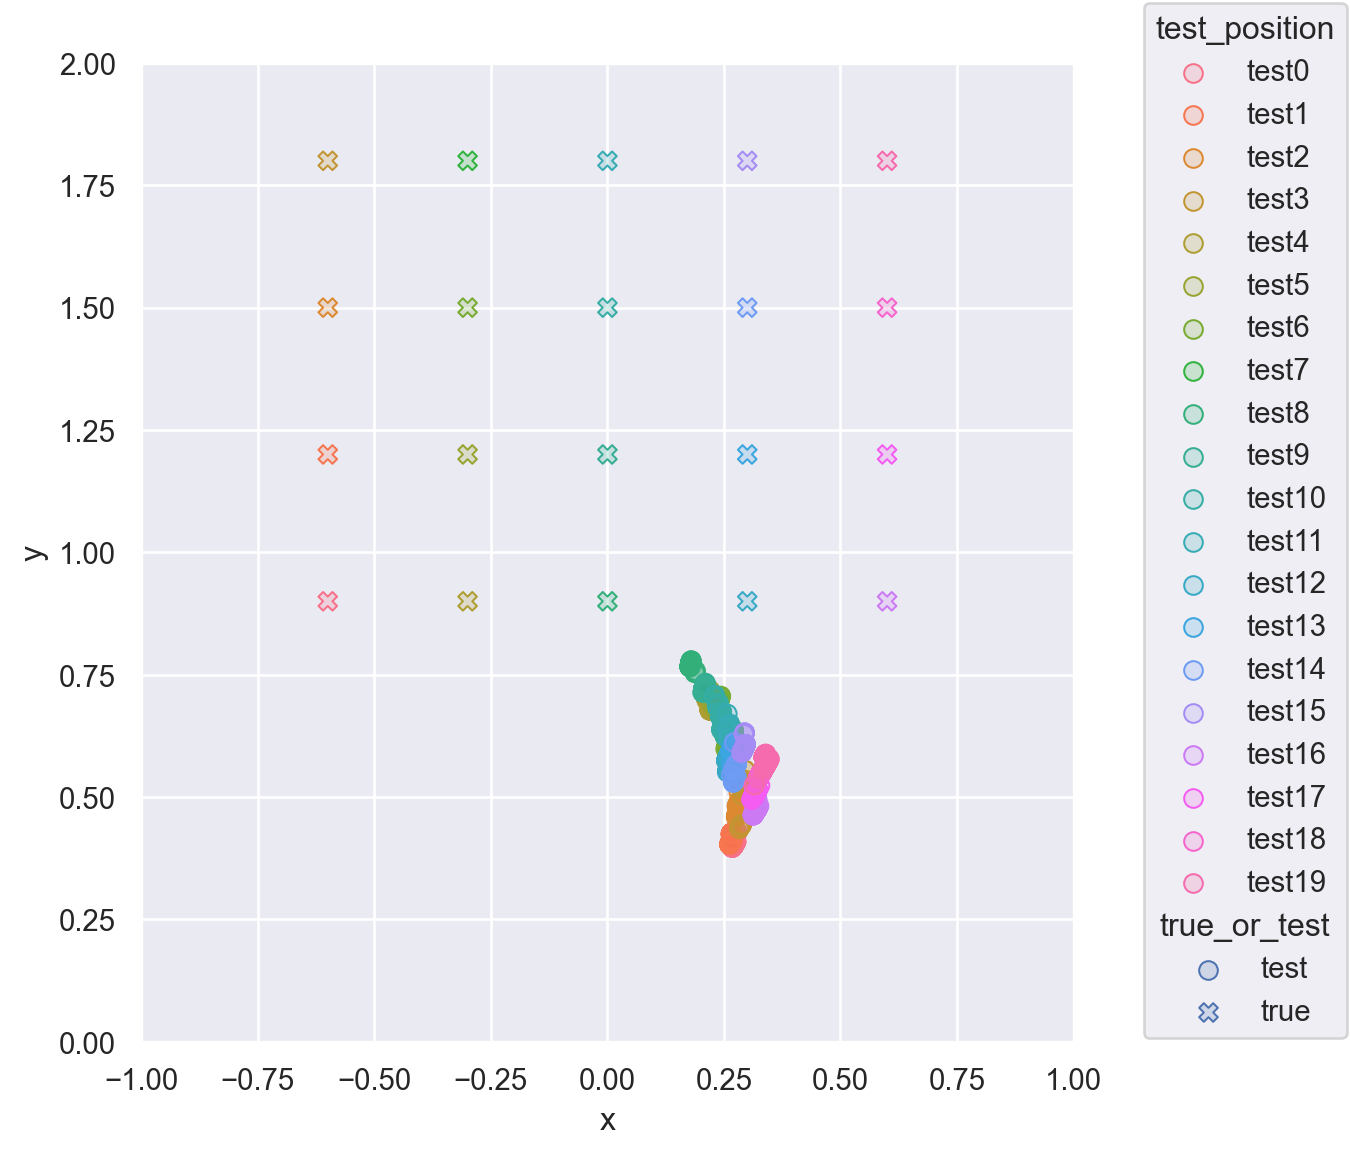

In [10]:
(
    so.Plot(df_positions, x="x", y="y", color="test_position", marker="true_or_test")
    .add(so.Dots(pointsize=7))
    .limit(x=(-1, 1), y=(0, 2))
    .layout(size=(6, 6))
)

In [11]:
fiftyth_p = []
ninetyth_p = []
test_points = df_est["test_position"].unique()
for p in test_points:
    fiftyth_p.append(np.percentile(df_est[df_est["test_position"] == p]["error"], 50))
    ninetyth_p.append(np.percentile(df_est[df_est["test_position"] == p]["error"], 90))
df_cdf = pd.DataFrame(
    {"test_position": test_points, "50th": fiftyth_p, "90th": ninetyth_p}
)
df_cdf.head(20)

,test_position,50th,90th
0,test0,1.003226,1.003730
1,test1,1.172617,1.173514
2,test2,1.357804,1.359564
3,test3,1.556282,1.558224
4,test4,0.565337,0.565658
5,test5,0.727633,0.743456
6,test6,1.033554,1.053982
7,test7,1.321068,1.323856
8,test8,0.219609,0.221634
9,test9,0.520803,0.523506
